# Pass maps

In [1]:
import pandas as pd
from mplsoccer.pitch import Pitch

In [2]:
df = pd.read_csv('open-data/valladolidA.csv')
df.head()

,id,eventId,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY
0,2248226915,2,0,0.0,Barcelona,0.0,0.0,1,Start,Successful,NaN,NaN,NaN
1,2248226919,2,0,0.0,Valladolid,0.0,0.0,1,Start,Successful,NaN,NaN,NaN
2,2248226929,3,0,1.0,Barcelona,50.0,50.0,1,Pass,Successful,9.0,43.9,46.9
3,2248226941,4,0,2.0,Barcelona,43.8,46.9,1,Pass,Successful,8.0,36.4,56.0
4,2248226951,5,0,4.0,Barcelona,36.6,56.6,1,Pass,Successful,21.0,28.5,73.8


X and Y is most important (locations)

---

## Barca

We want to see the average passing map of a possession-based team (here, Barca) 

In [3]:
df = df[df.teamId == 'Barcelona']

In [4]:
df['passer'] = df['playerId']
df['recipient'] = df['playerId'].shift(-1) # shift playerid up one row (the way this works is that the pass goes to the below id)

passes = df[df.type == 'Pass']
success = passes[passes.outcome == 'Successful']

In [5]:
success

,id,eventId,minute,second,teamId,x,y,period,type,outcome,playerId,endX,endY,passer,recipient
2,2248226929,3,0,1.0,Barcelona,50.0,50.0,1,Pass,Successful,9.0,43.9,46.9,9.0,8.0
3,2248226941,4,0,2.0,Barcelona,43.8,46.9,1,Pass,Successful,8.0,36.4,56.0,8.0,21.0
4,2248226951,5,0,4.0,Barcelona,36.6,56.6,1,Pass,Successful,21.0,28.5,73.8,21.0,15.0
5,2248226973,6,0,5.0,Barcelona,28.3,74.1,1,Pass,Successful,15.0,11.6,51.8,15.0,1.0
6,2248226975,7,0,8.0,Barcelona,11.2,53.7,1,Pass,Successful,1.0,11.6,81.4,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1651,2248256867,1018,93,14.0,Barcelona,76.7,31.8,2,Pass,Successful,8.0,76.7,43.0,8.0,10.0
1652,2248256869,1019,93,17.0,Barcelona,79.6,24.2,2,Pass,Successful,10.0,77.1,53.6,10.0,14.0
1653,2248256983,1020,93,18.0,Barcelona,77.1,56.4,2,Pass,Successful,14.0,69.0,56.9,14.0,44721.0
1654,2248256989,1021,93,20.0,Barcelona,68.3,55.2,2,Pass,Successful,44721.0,87.0,17.3,44721.0,2.0


Need to find avg locations of players and how many times those passes happened

In [6]:
subs = df[df.type == 'SubstitutionOff']
subs = subs.minute
firstsub = subs.min()

In [7]:
success = success[success.minute < firstsub]

In [8]:
pas = pd.to_numeric(success.passer,downcast='integer')
rec = pd.to_numeric(success.recipient,downcast='integer')

In [9]:
success['passer'] = pas
success['recipient'] = rec

/var/folders/bv/h7ss9cs93lq15v21yc62bk600000gn/T/ipykernel_78761/2178142100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success['passer'] = pas
/var/folders/bv/h7ss9cs93lq15v21yc62bk600000gn/T/ipykernel_78761/2178142100.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success['recipient'] = rec


---

In [10]:
avg_locations = success.groupby('passer').agg({'x':['mean'],'y':['mean','count']})
avg_locations.columns = ['x','y','count']

In [11]:
avg_locations

,x,y,count
passer,,,
1,7.124000,50.324000,25
2,68.274359,11.915385,39
4,32.895833,43.518750,48
8,53.332927,41.608537,82
9,69.916667,51.383333,6
10,63.201613,42.351613,62
15,38.409091,74.378182,55
16,69.594286,69.471429,35
18,55.242553,83.793617,47


In [12]:
pass_between = success.groupby(['passer','recipient']).id.count().reset_index()
pass_between.rename({'id':'pass_count'},axis='columns',inplace=True)

In [13]:
pass_between = pass_between.merge(avg_locations,left_on='passer',right_index=True)
pass_between = pass_between.merge(avg_locations,left_on='recipient',right_index=True,suffixes=[' ','_end'])

In [14]:
pass_between

,passer,recipient,pass_count,x,y,count,x_end,y_end,count_end
0,1,2,3,7.124000,50.324000,25,68.274359,11.915385,39
1,1,4,3,7.124000,50.324000,25,32.895833,43.518750,48
2,1,8,4,7.124000,50.324000,25,53.332927,41.608537,82
3,1,9,1,7.124000,50.324000,25,69.916667,51.383333,6
4,1,15,4,7.124000,50.324000,25,38.409091,74.378182,55
...,...,...,...,...,...,...,...,...,...
85,28,8,13,49.156863,16.282353,51,53.332927,41.608537,82
86,28,9,3,49.156863,16.282353,51,69.916667,51.383333,6
87,28,10,5,49.156863,16.282353,51,63.201613,42.351613,62
88,28,18,1,49.156863,16.282353,51,55.242553,83.793617,47


In [15]:
pass_between = pass_between[pass_between.pass_count > 3]

In [22]:
pass_between.columns

Index(['passer', 'recipient', 'pass_count', 'x ', 'y ', 'count ', 'x_end',
       'y_end', 'count_end'],
      dtype='object')

---

## Create Pitch

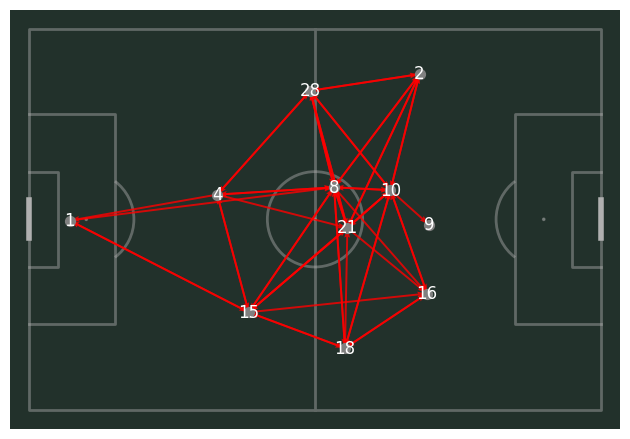

In [61]:
p = Pitch(pitch_type='statsbomb',pitch_color='#22312b',positional=False,line_alpha=0.44,shade_alpha=0.3,shade_zorder=0.2,) 
fig,ax = p.draw()

arrows = p.arrows(1.2*pass_between['x '],0.8*pass_between['y '],1.2*pass_between.x_end,0.8*pass_between.y_end,ax=ax,
                 width=1.4,alpha=0.8,color='red')
nodes = p.scatter(1.2*avg_locations.x,0.8*avg_locations.y,s=50,c='grey',ax=ax)

for idx, row in avg_locations.iterrows():
    ax.text(
        1.2 * row['x'], 0.8 * row['y'], str(idx), 
        fontsize=12, color='white', ha='center', va='center'
    )
